FACET is composed of the following key components:

* **sklearndf**:  

    An augmented version of scikit-learn with enhanced support for pandas dataframes and pipelining.


* **Enhanced machine learning workflow**:

    FACET delivers a robust and fail-safe pipelining workflow which allows you to easily impute and select your features as well as ranking a grid of different models "competing" against each other


* **Model Inspection**:

    Local explanations of features and their interactions make up a key component of understanding feature importance as well as feature interactions. This is based on a novel method which decomposes SHAP values into three vectors representing synergy, redundancy, and independence.


* **Model Simulation**:

    Use your trained model and the insights from the model inspection to conduct a historical simulation of any feature on your target in order to identify local optima.

In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx


def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os

    if "cwd" not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(
                0, os.path.abspath(f"{cwd}/facet/{os.pardir}/{module_path}/src")
            )
        print(f"added `{sys.path[0]}` to python paths")


_set_paths()

del _set_paths

import warnings

warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt

def _configure_matplotlib():
    # set global options for matplotlib

    import matplotlib

    matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
    matplotlib.rcParams["figure.dpi"] = 72


_configure_matplotlib()

del _configure_matplotlib

working dir is 'C:\Projects\facet'
added `C:\Projects\facet\pytools\src` to python paths
added `C:\Projects\facet\facet\src` to python paths
added `C:\Projects\facet\sklearndf\src` to python paths


# Pipelining & Model Ranking

In [2]:
# standard imports
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import RepeatedKFold

# some helpful imports from sklearndf
from sklearndf.pipeline import RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF

# relevant FACET imports
from facet.data import Sample
from facet.selection import LearnerRanker, LearnerGrid

# load Boston housing dataset
boston = load_boston()
df = pd.DataFrame(data=boston.data, columns=boston.feature_names).assign(
    MEDIAN_HOUSE_PRICE=boston.target
)

# create FCAET sample object
boston_obs = Sample(observations=df, target="MEDIAN_HOUSE_PRICE")

# create pipeline for random forest regressor
rforest_reg = RegressorPipelineDF(regressor=RandomForestRegressorDF(random_state=42))

# define grid of models which are "competing" against each other
rforest_grid = [
    LearnerGrid(
        pipeline=rforest_reg, learner_parameters={"min_samples_leaf": [8, 11, 15]}
    )
]

# create repeated k-fold CV iterator
rkf_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# rank your models by performance (default is variance explained)
ranker = LearnerRanker(grids=rforest_grid, cv=rkf_cv, n_jobs=-3).fit(sample=boston_obs)

# get summary report
print(ranker.summary_report())

Rank  1: RandomForestRegressorDF, ranking_score=    0.722, scores_mean=    0.813, scores_std=   0.0455, parameters={regressor__min_samples_leaf=8}

Rank  2: RandomForestRegressorDF, ranking_score=    0.707, scores_mean=    0.802, scores_std=   0.0471, parameters={regressor__min_samples_leaf=11}

Rank  3: RandomForestRegressorDF, ranking_score=    0.693, scores_mean=    0.789, scores_std=   0.0481, parameters={regressor__min_samples_leaf=15}



# Easy model inspection

FACET implements several model inspection methods for scikit-learn base learners. Fundamentally, FACET enables post-hoc model inspection by breaking down the interaction effects of the variables that your model used for training:

* ***Redundancy identifies groups of variables that fully or partially duplicate each other*** and do not deliver any additional information to the machine learning model.


* ***Synergy provides visibility about how features contain complementary information*** with respect to the target and team up to predict outcomes by combining their information.

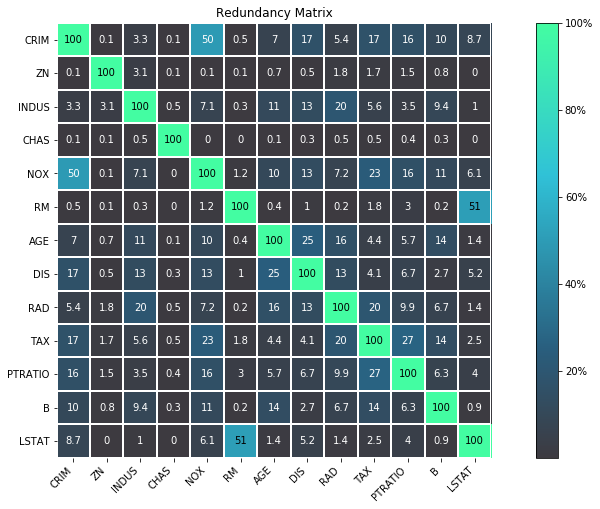

In [3]:
# fit the model inspector
from facet.inspection import LearnerInspector
inspector = LearnerInspector()
inspector.fit(crossfit=ranker.best_model_crossfit)

# visualise redundancy as a matrix
from pytools.viz.matrix import MatrixDrawer
redundancy_matrix = inspector.feature_redundancy_matrix()
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy Matrix")

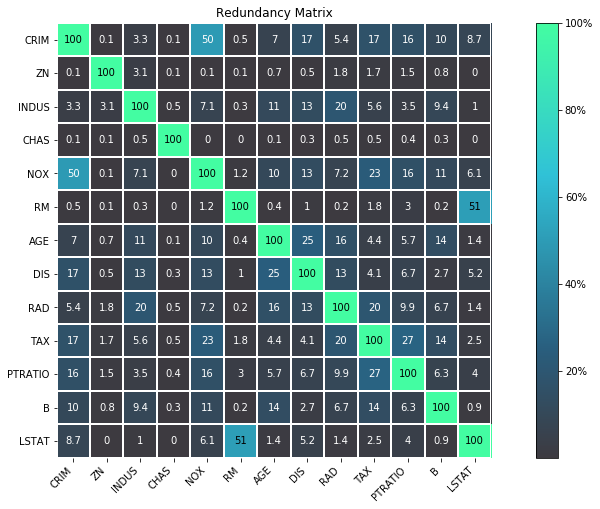

In [4]:
# save copy of plot to _static directories for documentation
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy Matrix")
plt.savefig("facet/_static/redundancy_matrix.png", bbox_inches="tight", pad_inches=0)
plt.savefig(
    "facet/sphinx/source/_static/redundancy_matrix.png",
    bbox_inches="tight",
    pad_inches=0,
)

We can also better visualize redundancy as a dendrogram so we can identify clusters of features with redundancy.

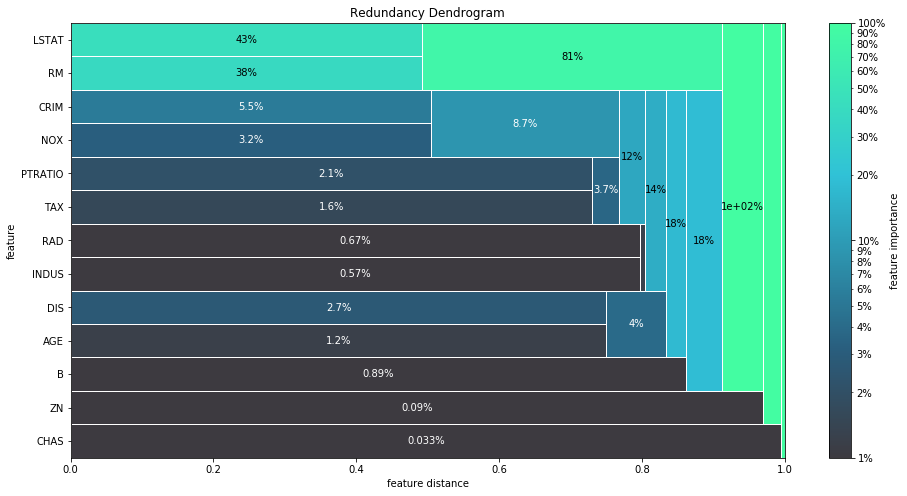

In [5]:
# visualise redundancy using a dendrogram
from pytools.viz.dendrogram import DendrogramDrawer
redundancy = inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(data=redundancy, title="Redundancy Dendrogram")

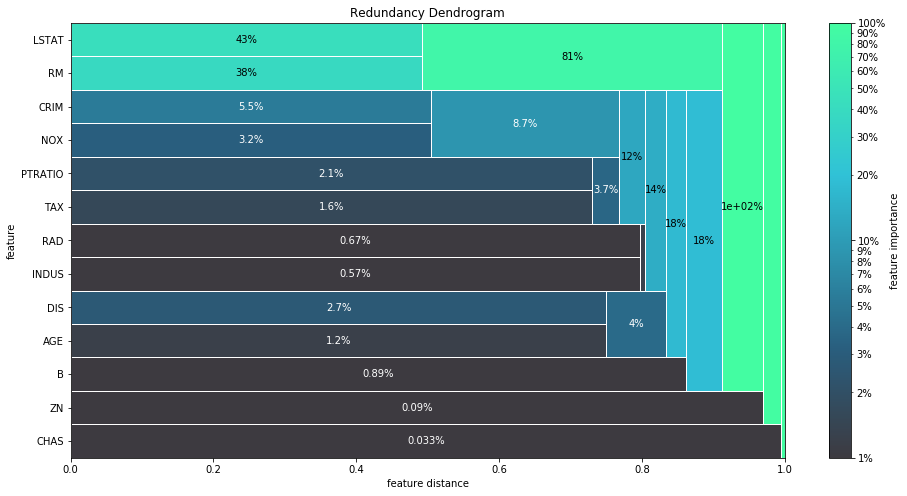

In [6]:
# save copy of plot to _static directories for documentation
DendrogramDrawer().draw(data=redundancy, title="Redundancy Dendrogram")
plt.savefig(
    "facet/_static/redundancy_dendrogram.png", bbox_inches="tight", pad_inches=0
)
plt.savefig(
    "facet/sphinx/source/_static/redundancy_dendrogram.png",
    bbox_inches="tight",
    pad_inches=0,
)

For feature synergy, we can get a similar picture

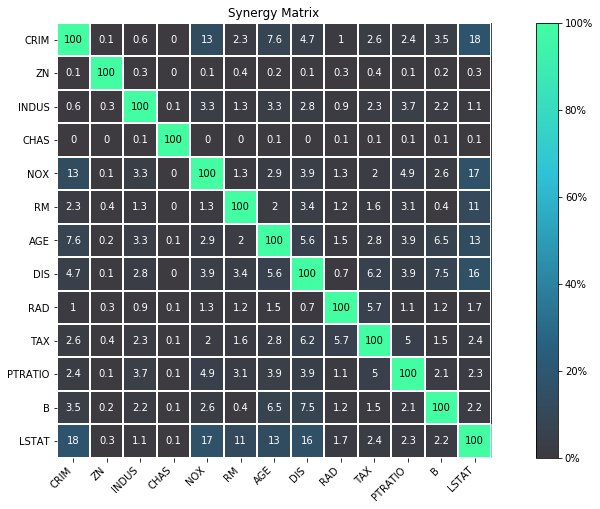

In [7]:
# visualise synergy as a matrix
synergy_matrix = inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy Matrix")

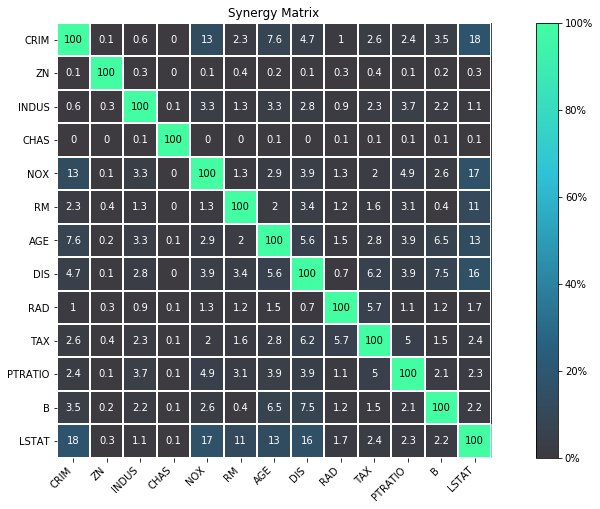

In [8]:
# save copy of plot to _static directories for documentation
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy Matrix")
plt.savefig("facet/_static/synergy_matrix.png", bbox_inches="tight", pad_inches=0)
plt.savefig(
    "facet/sphinx/source/_static/synergy_matrix.png", bbox_inches="tight", pad_inches=0
)

Please see the API documentation for more detail.

# Simulation

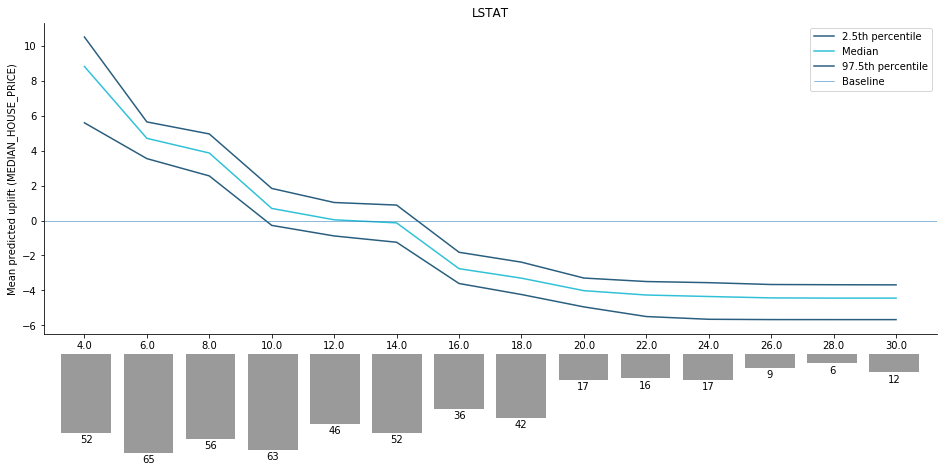

In [9]:
# FACET imports
from facet.validation import BootstrapCV
from facet.crossfit import LearnerCrossfit
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation.viz import SimulationDrawer

# create bootstrap CV iterator
bscv = BootstrapCV(n_splits=1000, random_state=42)

# create a bootstrap CV crossfit for simulation using best model
boot_crossfit = LearnerCrossfit(
    pipeline=ranker.best_model.native_estimator,
    cv=bscv,
    n_jobs=-3,
    verbose=False,
).fit(sample=boston_obs)

SIM_FEAT = "LSTAT"
simulator = UnivariateUpliftSimulator(crossfit=ranker.best_model_crossfit, n_jobs=3)

# split the simulation range into equal sized partitions
partitioner = ContinuousRangePartitioner()

# run the simulation
simulation = simulator.simulate_feature(name=SIM_FEAT, partitioner=partitioner)

# visualise results
SimulationDrawer().draw(data=simulation, title=SIM_FEAT)

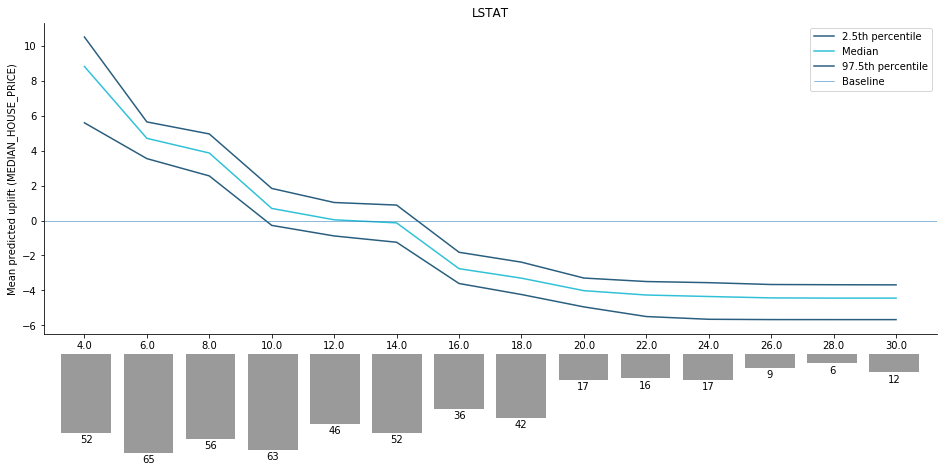

In [10]:
# save copy of plot to _static directories for documentation
SimulationDrawer().draw(data=simulation, title=SIM_FEAT)
plt.savefig("facet/_static/simulation_output.png", bbox_inches="tight", pad_inches=0)
plt.savefig(
    "facet/sphinx/source/_static/simulation_output.png",
    bbox_inches="tight",
    pad_inches=0,
)